##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 14 - Adventures in Covariance

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/14_adventures_in_covariance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/14_adventures_in_covariance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/14_adventures_in_covariance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/14_adventures_in_covariance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions


In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [4]:
#@title Install { display-mode: "form" }

# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [5]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, transforms

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [6]:
az.style.use('seaborn-colorblind')

## Sampling helpers


In [7]:
USE_XLA = False              #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )



In [8]:
NUMBER_OF_SAMPLES = 2000           #@param

MCMC_NUMBER_OF_CHAINS  = 2         #@param 
MCMC_NUMBER_OF_BURNIN  = 1000      #@param
MCMC_NUMBER_OF_LEAPFROG_STEPS = 4  #@param

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=MCMC_NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=MCMC_NUMBER_OF_BURNIN):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
    )         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors,
    )       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = []
    bijectors = []
    for p in params:
        init_state.append(init_config[p]['state'])
        bijectors.append(init_config[p]['bijector'])

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  
    
    
    step_size  = mcmc_config.get('step_size', 0.1)
    num_chains = mcmc_config.get('num_chains', MCMC_NUMBER_OF_CHAINS)
    burnin     = mcmc_config.get('burnin', MCMC_NUMBER_OF_BURNIN)
    
    results, sample_stats = run_hmc_chain(
        init_state,
        bijectors,
        step_size=step_size,
        target_log_prob_fn=target_log_prob_fn,                                      
        num_samples=num_samples, 
        burnin=burnin,
    )

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

    return posterior, az_trace

## Dataset URLs


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

CHIMPANZEE_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"
KOSTER_LECKIE_DATASET_PATH = f"{_BASE_URL}/KosterLeckie.csv"
ISLANDS_DISTMATRIX_DATASET_PATH = f"{_BASE_URL}/islandsDistMatrix.csv"
KLINE_DATASET_PATH = f"{_BASE_URL}/Kline2.csv"
PRIMATES301_DATASET_PATH = f"{_BASE_URL}/Primates301.csv"
PRIMATES301_VCOV_DATASET_PATH = f"{_BASE_URL}/Primates301_vcov_matrix.csv"
PRIMATES301_DISTANCE_DATASET_PATH = f"{_BASE_URL}/Primates301_distance_matrix.csv"

# Introduction

## 14.1 Varying slopes by construction

### 14.1.1 Simulate the population

##### Code 14.1

Simulate the population

In [10]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

##### Code 14.2

In [11]:
Mu = tf.constant([a, b])

The value in a is the mean intercept, the wait in the morning. And the value in b is the mean slope, the difference in wait between afternoon and morning

##### Code 14.3

In [12]:
cov_ab = sigma_a * sigma_b * rho
Sigma = tf.constant([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])

##### Code 14.4

In [13]:
tf.transpose(tf.reshape(tf.constant([1, 2, 3, 4]), (2, 2)))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 3],
       [2, 4]], dtype=int32)>

##### Code 14.5

In [14]:
sigmas = tf.constant([sigma_a, sigma_b])  # standard deviations
Rho = tf.constant([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = tf.linalg.tensor_diag(sigmas) @ Rho @ tf.linalg.tensor_diag(sigmas)

Sigma

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.  , -0.35],
       [-0.35,  0.25]], dtype=float32)>

##### Code 14.6

In [15]:
N_cafes = 20

##### Code 14.7

In [16]:
def build_vary_effects():
  _seed = 5
  tf.random.set_seed(_seed)

  seed = tfp.util.SeedStream(_seed, salt="vary_effects")    
  
  Mu = tf.constant([a, b])  

  vary_effects = tfd.MultivariateNormalTriL(
      loc=Mu,
      scale_tril=tf.linalg.cholesky(Sigma)).sample((N_cafes,), seed=seed())
    

  return vary_effects

vary_effects = build_vary_effects()

##### Code 14.8

In [17]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

##### Code 14.9

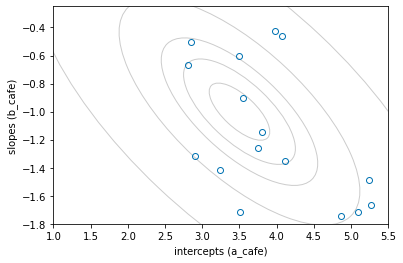

In [18]:
plt.plot(a_cafe, b_cafe, "o", mfc="none")
plt.gca().set(xlabel="intercepts (a_cafe)", ylabel="slopes (b_cafe)")
plt.xlim((1.0,5.5))
plt.ylim((-1.8,-0.25))

# overlay population distribution
# Ref: https://matplotlib.org/gallery/statistics/confidence_ellipse.html
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma[0, 1] / np.sqrt(Sigma[0, 0] * Sigma[1, 1])
    ellipse = Ellipse((0, 0), np.sqrt(1 + pearson), np.sqrt(1 - pearson),
                      edgecolor="k", alpha=0.2, facecolor="none")
    std_dev = tfd.Normal(loc=0.,scale=1.).quantile((1 + np.sqrt(l)) / 2)
    scale_x = 2 * std_dev * np.sqrt(Sigma[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu[0], Mu[1]) + plt.gca().transData)
    plt.gca().add_patch(ellipse)

### 14.1.2 Simulate observations

##### Code 14.10

The data we’re generating describes the waiting times in 20 different cafés. Each café has a different average waiting times in the morning and in the afternoon. The average morning waiting time is the intercept, and the difference between afternoon and morning average waiting times is the slope. 

In [19]:
N_visits = 10
afternoon = np.tile(np.arange(2), N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

def generate_data_frame():
  sigma = 0.5  # std dev within cafes

  _seed = 22
  tf.random.set_seed(_seed)

  seed = tfp.util.SeedStream(_seed, salt="generate_data_frame")    

  mu = tf.gather(a_cafe, cafe_id) + tf.gather(b_cafe, cafe_id) * afternoon

  wait = tfd.Normal(loc=mu, scale=sigma).sample(seed=seed())
  d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

  return d

d = generate_data_frame()

d.describe()

,cafe,afternoon,wait
count,200.000000,200.000000,200.000000
mean,9.500000,0.500000,3.145164
std,5.780751,0.501255,1.103819
min,0.000000,0.000000,0.627383
25%,4.750000,0.000000,2.435770
50%,9.500000,0.500000,3.129436
75%,14.250000,1.000000,3.787630
max,19.000000,1.000000,6.477736


### 14.1.3 The vaying slopes model

##### Code 14.11

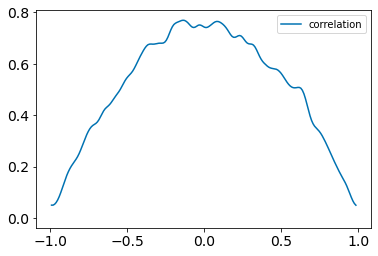

In [20]:
R = tfp.distributions.LKJ(dimension=2, concentration=2).sample((int(1e4),))
az.plot_kde(R[:, 0, 1], bw=2, label="correlation");

In [21]:
R.shape

TensorShape([10000, 2, 2])

##### Code 14.12

In [22]:
def model_14_1(cafe, afternoon):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=5.,scale=2.), sample_shape=1))
        beta  = yield Root(tfd.Sample(tfd.Normal(loc=-1., scale=0.5), sample_shape=1))        
#         sigma = yield Root(tfd.Sample(tfd.HalfCauchy(loc=0., scale=1.), sample_shape=1))
#         sigma_alpha_beta = yield Root(tfd.Sample(tfd.HalfCauchy(loc=0., scale=1.), sample_shape=2))        
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
        sigma_alpha_beta = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2))        
#        Rho = yield Root(tfd.Sample(tfd.LKJ(dimension=2, concentration=2.), sample_shape=1))  
        Rho = yield Root(tfd.LKJ(dimension=2, concentration=2.))      
        
        Mu = tf.concat([alpha, beta], axis=-1)
        scale = tf.linalg.LinearOperatorDiag(sigma_alpha_beta).matmul(tf.squeeze(Rho))
        
        a_cafe_b_cafe = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = Mu,
                        scale_tril = scale
                    ),sample_shape=20)

        # extract the alphas and betas
        a_cafe = tf.gather(a_cafe_b_cafe, 0, axis=-1)
        b_cafe = tf.gather(a_cafe_b_cafe, 1, axis=-1)
        
        # extract alphas and beta using the cafe id as the index
        term1 = tf.gather(a_cafe, cafe, axis=-1)
        term2 = tf.gather(b_cafe, cafe, axis=-1)
    
        # linear model
        mu = term1 + term2 * afternoon        
        
        wait = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)
        
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False) 
        
        
jdc_14_1 = model_14_1(tf.cast(d.cafe.values, dtype=tf.int32), tf.cast(d.afternoon.values, dtype=tf.float32))

In [23]:
alpha_init, beta_init, sigma_init, sigma_alpha_beta_init, Rho_init, a_cafe_b_cafe_init, _ = jdc_14_1.sample(2)

# let's see Rho and make sure that what we have
# looks like a correlation matrix as a sanity check
#
# Now this will a prior sample so most likely
# we will get the correct sample however when we will do HMC
# we maybe extra care
# alpha_init, beta_init, sigma_init, sigma_alpha_beta_init, Rho_init, a_cafe_b_cafe_init
Rho_init

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[ 1.        ,  0.16966414],
        [ 0.16966414,  1.        ]],

       [[ 1.        , -0.13546377],
        [-0.13546377,  1.        ]]], dtype=float32)>

In [24]:
init_rho = tf.stack([tf.eye(2) for _ in range(2)])

init_rho

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]], dtype=float32)>

In [25]:
init_state = [
    alpha_init,
    beta_init,
    sigma_init,
    sigma_alpha_beta_init,
    init_rho,
    a_cafe_b_cafe_init
]


init_config = dict(
    alpha   = dict(state=init_state[0], bijector=tfb.Identity()),
    beta    = dict(state=init_state[1], bijector=tfb.Identity()),
    sigma   = dict(state=init_state[2], bijector=tfb.Identity()),
    sigma_alpha_beta = dict(state=init_state[3], bijector=tfb.Identity()),
    Rho       = dict(state=init_state[4], bijector=tfb.CorrelationCholesky()),   
    a_cafe_b_cafe       = dict(state=init_state[5], bijector=tfb.Identity())
    
)

observed_data = (tf.cast(d.wait.values, dtype=tf.float32),)

posterior_14_1, trace_14_1 = sample_posterior(
                                    jdc_14_1, 
                                    init_config=init_config,
                                    observed_data=observed_data)

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


##### Code 14.13

In [26]:
post = trace_14_1.posterior

# Here comes the important part !
#
# The posterior that we get is not really Rho because of the bijector
# that we used. Hence we need to get the correlation matrix back (i.e. Rho)

states = post["Rho"].values

rhos = states @ tf.transpose(states,[0,1,3,2])

# let's look at the rhos
# we should see that it will be a collection of 2x2 matrices such that on diagnoal you would
# see the ones
rhos

<tf.Tensor: shape=(2, 2000, 2, 2), dtype=float32, numpy=
array([[[[ 1.        ,  0.712666  ],
         [ 0.712666  ,  1.        ]],

        [[ 1.        ,  0.6364455 ],
         [ 0.6364455 ,  1.        ]],

        [[ 1.        ,  0.6364455 ],
         [ 0.6364455 ,  1.        ]],

        ...,

        [[ 1.        ,  0.5768809 ],
         [ 0.5768809 ,  1.        ]],

        [[ 1.        ,  0.60758823],
         [ 0.60758823,  0.99999994]],

        [[ 1.        ,  0.60758823],
         [ 0.60758823,  0.99999994]]],


       [[[ 1.        , -0.73067796],
         [-0.73067796,  0.9999999 ]],

        [[ 1.        , -0.73067796],
         [-0.73067796,  0.9999999 ]],

        [[ 1.        , -0.6637264 ],
         [-0.6637264 ,  0.9999999 ]],

        ...,

        [[ 1.        , -0.5385513 ],
         [-0.5385513 ,  1.        ]],

        [[ 1.        , -0.5385513 ],
         [-0.5385513 ,  1.        ]],

        [[ 1.        , -0.45816442],
         [-0.45816442,  0.99999994]]]], 

In [27]:
rhos[0]

<tf.Tensor: shape=(2000, 2, 2), dtype=float32, numpy=
array([[[1.        , 0.712666  ],
        [0.712666  , 1.        ]],

       [[1.        , 0.6364455 ],
        [0.6364455 , 1.        ]],

       [[1.        , 0.6364455 ],
        [0.6364455 , 1.        ]],

       ...,

       [[1.        , 0.5768809 ],
        [0.5768809 , 1.        ]],

       [[1.        , 0.60758823],
        [0.60758823, 0.99999994]],

       [[1.        , 0.60758823],
        [0.60758823, 0.99999994]]], dtype=float32)>

In [28]:
rhos[1][:,0,1]

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([-0.73067796, -0.73067796, -0.6637264 , ..., -0.5385513 ,
       -0.5385513 , -0.45816442], dtype=float32)>

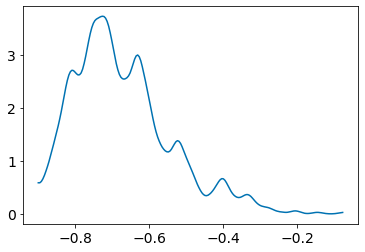

In [29]:
az.plot_kde(rhos[1][:,0,1], bw=2);

##### Code 14.14

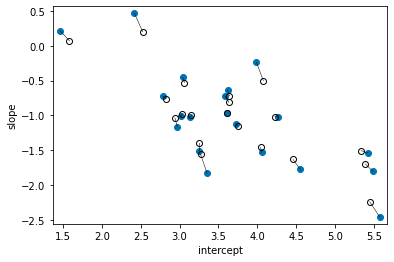

In [30]:
a1 = np.array([np.mean(d.wait[(cafe_id == i) & (afternoon == 0)])
               for i in range(N_cafes)])
b1 = np.array([np.mean(d.wait[(cafe_id == i) & (afternoon == 1)])
               for i in range(N_cafes)]) - a1

# extract posterior means of partially pooled estimates
a2 = np.mean(post["a_cafe_b_cafe"].values[0][..., 0], 0)
b2 = np.mean(post["a_cafe_b_cafe"].values[0][..., 1], 0)

# plot both and connect with lines
plt.plot(a1, b1, "o")
plt.gca().set(xlabel="intercept", ylabel="slope",
              ylim=(np.min(b1) - 0.1, np.max(b1) + 0.1),
              xlim=(np.min(a1) - 0.1, np.max(a1) + 0.1))
plt.plot(a2, b2, "ko", mfc="none")

for i in range(N_cafes):
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], "k", lw=0.5)
fig, ax = plt.gcf(), plt.gca()

##### Code 14.15

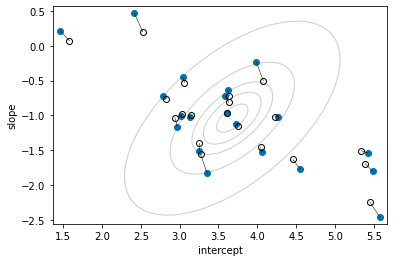

In [31]:
# compute posterior mean bivariate Gaussian
Mu_est = np.array([np.mean(post["alpha"].values[0]), np.mean(post["beta"].values[0])])
rho_est = np.mean(post["Rho"][0, 1])

sa_est = np.mean(post["sigma"][:, 0])
sb_est = np.mean(post["sigma"][:, 1])

cov_ab = sa_est * sb_est * rho_est
Sigma_est = np.array([[sa_est ** 2, cov_ab], [cov_ab, sb_est ** 2]])

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est[0, 1] / np.sqrt(Sigma_est[0, 0] * Sigma_est[1, 1])
    ellipse = Ellipse((0, 0), np.sqrt(1 + pearson), np.sqrt(1 - pearson),
                      edgecolor="k", alpha=0.2, facecolor="none")
    
    
    std_dev = tfd.Normal(loc=0.,scale=1.).quantile((1 + np.sqrt(l)) / 2)
    
    scale_x = 2 * std_dev * np.sqrt(Sigma_est[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma_est[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu_est[0], Mu_est[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

##### Code 14.16

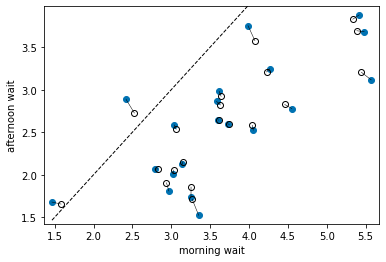

In [32]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

# plot both and connect with lines
plt.plot(wait_morning_1, wait_afternoon_1, "o")
plt.gca().set(
    xlabel="morning wait", ylabel="afternoon wait",
    ylim=(np.min(wait_afternoon_1) - 0.1, np.max(wait_afternoon_1) + 0.1),
    xlim=(np.min(wait_morning_1) - 0.1, np.max(wait_morning_1) + 0.1))
plt.plot(wait_morning_2, wait_afternoon_2, "ko", mfc="none")
for i in range(N_cafes):
    plt.plot([wait_morning_1[i], wait_morning_2[i]],
             [wait_afternoon_1[i], wait_afternoon_2[i]], "k", lw=0.5)
x = np.linspace(np.min(wait_morning_1), np.max(wait_morning_1), 101)
plt.plot(x, x, "k--", lw=1)
fig, ax = plt.gcf(), plt.gca()

##### Code 14.17

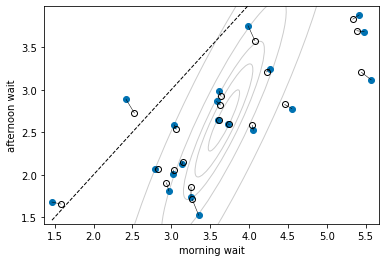

In [33]:
# now shrinkage distribution by simulation
v = tfd.MultivariateNormalTriL(loc=Mu_est, scale_tril=tf.linalg.cholesky(Sigma_est)).sample((10000,)).numpy()

v[:,1] = v[:,0] + v[:,1] # calculate afternoon wait

Sigma_est2 = np.cov(v, rowvar=False)

Mu_est2 = Mu_est

Mu_est2[1] = Mu_est2[0] + Mu_est2[1]

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est2[0, 1] / np.sqrt(Sigma_est2[0, 0] * Sigma_est2[1, 1])
    ellipse = Ellipse((0, 0), np.sqrt(1 + pearson), np.sqrt(1 - pearson),
                      edgecolor="k", alpha=0.2, facecolor="none")
        
    std_dev = tfd.Normal(loc=0.,scale=1.).quantile((1 + np.sqrt(l)) / 2)
    
    scale_x = 2 * std_dev * np.sqrt(Sigma_est2[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma_est2[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(
        scale.translate(Mu_est2[0], Mu_est2[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

## 14.2 Advanced varying slopes

##### Code 14.18

In [34]:
d = pd.read_csv(CHIMPANZEE_DATASET_PATH, sep=";")
d["block_id"] = d.block
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(L=d.pulled_left.values, tid=d.treatment.values - 1,
           actor=d.actor.values - 1, block_id=d.block_id.values - 1)

# actor 0 to 6 => 7
# tid 0 to 3 => 4

In [35]:
def model_14_2(tid, actor, block_id, num_chains):
    
    # we need to create the indexes that make
    # gather_nd happy
    actor_tid = tf.stack([actor, tid], axis=1)
    block_tid = tf.stack([block_id, tid], axis=1)
    batch_dims = 0
    
    if num_chains > 1:
        actor_tid_tiled =  tf.tile(actor_tid, (num_chains, 1))
        actor_tid_reshaped = tf.reshape(actor_tid_tiled, (num_chains, 504, 2))
        
        actor_tid = actor_tid_reshaped
        
        block_tid_tiled =  tf.tile(block_tid, (num_chains, 1))
        block_tid_reshaped = tf.reshape(block_tid_tiled, (num_chains, 504, 2))
        
        block_tid = block_tid_reshaped
        
        batch_dims = 1
        
    
    def _generator():
        # fixed priors
        g = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=4))
        sigma_actor = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=4))
        # note - not using Sample as it does not work with it
        rho_actor = yield Root(tfp.distributions.LKJ(dimension=4, concentration=4.))
        sigma_block = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=4))
        # note - not using Sample as it does not work with it
        rho_block = yield Root(tfp.distributions.LKJ(dimension=4, concentration=4.))
        # adaptive priors
        
        alpha = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = 0.,
                        scale_tril = tf.linalg.LinearOperatorDiag(sigma_actor).matmul(rho_actor)
                    ),sample_shape=7)
        
        beta = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = 0.,
                        scale_tril = tf.linalg.LinearOperatorDiag(sigma_block).matmul(rho_block)
                    ),sample_shape=6)
        
  
        print(alpha.shape)

        term1 = tf.gather(g, tid, axis=-1)
        term2 = tf.gather_nd(alpha, actor_tid, batch_dims=batch_dims)
        term3 = tf.gather_nd(alpha, block_tid, batch_dims=batch_dims)
        
        logit_p =  term1 + term2 + term3
        
        L = yield tfd.Independent(tfd.Binomial(total_count=1, logits=logit_p), reinterpreted_batch_ndims=1)
        
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False) 
        
    
jdc_14_2 = model_14_2(dat["tid"], dat["actor"], dat["block_id"], num_chains=1)

jdc_14_2.sample()

(7, 4)


StructTuple(var0=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.15466787,  0.53030187,  0.13563706, -0.5120716 ], dtype=float32)>, var1=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.9631015 , 0.59187365, 0.44238394, 0.04852653], dtype=float32)>, var2=<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.        ,  0.08410478, -0.5437963 , -0.25716713],
       [ 0.08410478,  1.        , -0.20940696,  0.11478234],
       [-0.5437963 , -0.20940696,  1.        , -0.30720332],
       [-0.25716713,  0.11478234, -0.30720332,  1.        ]],
      dtype=float32)>, var3=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.56216276, 0.70532846, 0.08683925, 0.5831806 ], dtype=float32)>, var4=<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.        , -0.00280792, -0.09555837,  0.20201829],
       [-0.00280792,  1.        ,  0.20828147,  0.1845984 ],
       [-0.09555837,  0.20828147,  1.        ,  0.5709721 ],
       [ 0.20201829,  0.1845984 ,  0.5709721 ,  1.        

In [36]:
g_init, sigma_actor_init, rho_actor_init, sigma_block_init, rho_block_init, alpha_init, beta_init, _ = jdc_14_2.sample()

(7, 4)


In [37]:
init_state = [
    g_init,
    sigma_actor_init,
    rho_actor_init, 
    sigma_block_init, 
    rho_block_init, 
    alpha_init, 
    beta_init,
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.CorrelationCholesky(),
    tfb.Exp(),
    tfb.CorrelationCholesky(),
    tfb.Identity(),
    tfb.Identity()
]




observed_data = (tf.cast(dat["L"], dtype=tf.float32),)


# Issue:
# This used to work
# posterior_14_2, trace_14_2 = sample_posterior(
#                                 jdc_14_2, 
#                                 observed_data=observed_data,
#                                 params=['g', 'sigma_actor', 'rho_actor', 'sigma_block', 'rho_block', 'alpha', 'beta'],
#                                 num_samples=2000,
#                                 burnin=500,
#                                 init_state=init_state,
#                                 bijectors=bijectors)

What is happening is that arviz assigns 7 to the chain dimension and this screws up the
entire structure in xarray. Really arviz does not work if there is 1 chain. 

Now I have problem using 2 chains so that is the real problem indeed !

In [38]:
# az.summary(trace_14_2)

## 14.3 Instruments and causal designs (TODO)

## 14.4 Social relations as correlated varying effects (TODO)

## 14.5 Continuous categories and the Gaussian process (TODO)